In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
import pandas as pd

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
num_classes = 4
input_size = 100
sequence_length = 200
hidden_size = 16
num_layers = 1
learning_rate = 0.001

In [4]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.manual_data_cache = []
        self.full_test_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('rnn*.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    print(gname)
                    if gname == 'neg_grenzflaeche':
                        label = 0
                    elif gname == 'neg_spitze':
                        label = 1
                    elif gname == 'pos_grenzflaeche':
                        label = 2
                    elif gname == 'pos_spitze':
                        label = 3

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 2501: #3000
                            self.train_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            k += 1
                        elif j < 401: # 400
                            self.test_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            j += 1
                        if k == 2500 and j == 400:
                            break
                                
    def __getitem__(self, index):
        return self.data_cache[index]

    def get_test_data(self):
        return self.test_data_cache

    def get_train_data(self):
        return self.train_data_cache

    def __len__(self):
        return len(self.data_cache)

In [5]:
customData = CustomDataset("/home/marcus/Dokumente/entladung/")

neg_grenzflaeche


100%|█████████████████████████████████████| 3500/3500 [00:01<00:00, 2961.83it/s]


neg_spitze


100%|█████████████████████████████████████| 4000/4000 [00:01<00:00, 3337.32it/s]


pos_grenzflaeche


100%|█████████████████████████████████████| 3500/3500 [00:01<00:00, 3088.15it/s]


pos_spitze


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 2623.62it/s]


In [6]:
train_data = customData.get_train_data()
test_data = customData.get_test_data()
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=0)
manual_dataloader = DataLoader(customData.manual_data_cache, batch_size=4, shuffle=False, pin_memory=False, num_workers=0)

In [7]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        #out, _ = self.rnn(x, h0)  
        # or:
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

In [8]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [9]:
# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = data[0]
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        # log statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    plt.plot(loss_values)

In [10]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    right_pred = []
    wrong_pred = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.reshape(-1, sequence_length, input_size).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true'), wrong_pred, right_pred



[0] Train Loss: 1.1675950720906259 
 Random Teilstück Error: Accuracy: 63.0%, Avg loss: 0.972466
[1] Train Loss: 0.8665491625666618 
 Random Teilstück Error: Accuracy: 91.2%, Avg loss: 0.786577
[2] Train Loss: 0.7158834904432296 
 Random Teilstück Error: Accuracy: 95.0%, Avg loss: 0.664478
[3] Train Loss: 0.6049361675977707 
 Random Teilstück Error: Accuracy: 96.8%, Avg loss: 0.560460
[4] Train Loss: 0.5154534801840782 
 Random Teilstück Error: Accuracy: 98.3%, Avg loss: 0.484500
[5] Train Loss: 0.44256729930639266 
 Random Teilstück Error: Accuracy: 99.0%, Avg loss: 0.412566
[6] Train Loss: 0.3856265522539616 
 Random Teilstück Error: Accuracy: 99.2%, Avg loss: 0.385883
[7] Train Loss: 0.34133577793836595 
 Random Teilstück Error: Accuracy: 99.2%, Avg loss: 0.324843
[8] Train Loss: 0.3013197273015976 
 Random Teilstück Error: Accuracy: 99.3%, Avg loss: 0.291701
[9] Train Loss: 0.26459483951330187 
 Random Teilstück Error: Accuracy: 99.5%, Avg loss: 0.253834
Finished Training


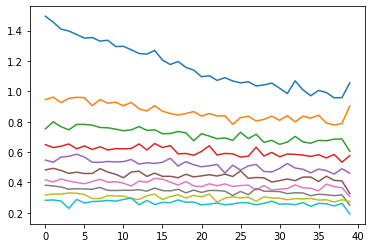

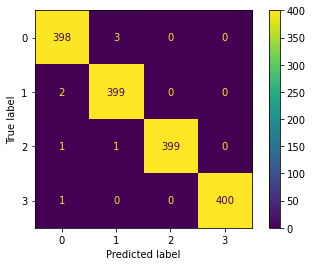

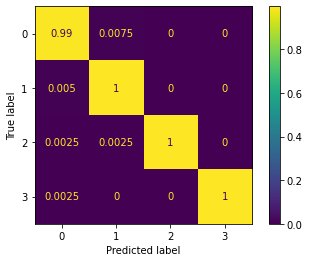

In [11]:
# training loop
for epoch in range(10):  # loop over the dataset multiple times
    loss_values=train(train_dataloader, optimizer, criterion, model)
    CM=split_test(test_dataloader, criterion, model)
print('Finished Training')

disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()

In [12]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

7620
